### Recommendations
- We are using different building ratings as input features (details how to generate that ratings are in 4_Analyzing scripts):
    - Hot_water
    - Lighting
    - Wall
    - Roof
    - Floor
    - Windows
    - Mainheat
    - Mainheatcont
- Ratings could be float then we convert them to the integer values from 1 to 5.
- In each categorical rating value we calculate average value of a target variable (energy costs or energy performance).
- Based on that matrix we calculate the maximum target improvement for each dwelling owner under the assumption that the owner can improve his feature rating only on 1.

In [1]:
plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

In [2]:
# 1) clean dataset
df = pd.read_csv('data/data_clean.csv')
df['Hot_water_rating'] = df.HOT_WATER_ENERGY_EFF
df['Lighting_rating'] = pd.cut(df.LIGHTING_DESCRIPTION, bins = [-np.inf,20,40,60,80,np.inf], labels = [1,2,3,4,5]).astype(int)
print(df.shape)
df[:3]

(185039, 30)


,Property_UPRN,Postcode,POST_TOWN,Primary Energy Indicator (kWh/m²/year),Total floor area (m²),Current energy efficiency rating,Potential Energy Efficiency Rating,Current Environmental Impact Rating,Potential Environmental Impact Rating,CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr),HOT_WATER_ENERGY_EFF,HOT_WATER_ENV_EFF,LIGHTING_DESCRIPTION,Current Emissions (T.CO2/yr),Potential Reduction in Emissions (T.CO2/yr),Total current energy costs over 3 years (£),Current heating costs over 3 years (£),Potential heating costs over 3 years (£),Current hot water costs over 3 years (£),Potential hot water costs over 3 years (£),Current lighting costs over 3 years (£),Potential lighting costs over 3 years (£),Part 1 Construction Age Band,Built Form,Property Type,dt_day,dt_month,Country,Hot_water_rating,Lighting_rating
0,1001100841,EH4 5EZ,EDINBURGH,375.00,94.00,53.00,85.00,45.00,82.00,66.00,2,2,100,6.20,4.20,"3,789.00","2,922.00","1,548.00",645.00,219.00,222.00,222.00,"1,949.00",Semi-Detached,House,2021-01-01,1,EDINBURGH,2,5
1,1001950838,EH7 4HE,EDINBURGH,250.00,175.00,66.00,80.00,57.00,75.00,44.00,4,4,100,7.70,2.80,"4,635.00","4,068.00","3,015.00",246.00,246.00,321.00,321.00,"1,929.00",End-Terrace,House,2021-01-01,1,EDINBURGH,4,5
2,1000995515,EH4 2DL,EDINBURGH,403.00,72.00,61.00,78.00,48.00,64.00,68.00,1,2,50,4.90,1.60,"3,570.00","2,226.00","1,191.00","1,038.00",564.00,306.00,207.00,"1,975.00",Semi-Detached,Flat,2021-02-01,2,EDINBURGH,1,3


In [3]:
# 2) merge with preprocessed description features:
df1 = pd.read_csv('data/features/WALL_DESCRIPTION.csv', sep = '|')
df = df.merge(df1, on = 'Property_UPRN', how = 'left')

df1 = pd.read_csv('data/features/ROOF_DESCRIPTION.csv', sep = '|')
df = df.merge(df1, on = 'Property_UPRN', how = 'left')

df1 = pd.read_csv('data/features/FLOOR_DESCRIPTION.csv', sep = '|')
df = df.merge(df1, on = 'Property_UPRN', how = 'left')

df1 = pd.read_csv('data/features/WINDOWS_DESCRIPTION.csv', sep = '|')
df = df.merge(df1, on = 'Property_UPRN', how = 'left')

df1 = pd.read_csv('data/features/MAINHEAT_DESCRIPTION.csv', sep = '|')
df = df.merge(df1, on = 'Property_UPRN', how = 'left')

df1 = pd.read_csv('data/features/MAINHEATCONT_DESCRIPTION.csv', sep = '|')
df = df.merge(df1, on = 'Property_UPRN', how = 'left')

In [4]:
# print features for convenient working
for f in df.columns:
    print(f'"{f}",')

"Property_UPRN",
"Postcode",
"POST_TOWN",
"Primary Energy Indicator (kWh/m²/year)",
"Total floor area (m²)",
"Current energy efficiency rating",
"Potential Energy Efficiency Rating",
"Current Environmental Impact Rating",
"Potential Environmental Impact Rating",
"CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)",
"HOT_WATER_ENERGY_EFF",
"HOT_WATER_ENV_EFF",
"LIGHTING_DESCRIPTION",
"Current Emissions (T.CO2/yr)",
"Potential Reduction in Emissions (T.CO2/yr)",
"Total current energy costs over 3 years (£)",
"Current heating costs over 3 years (£)",
"Potential heating costs over 3 years (£)",
"Current hot water costs over 3 years (£)",
"Potential hot water costs over 3 years (£)",
"Current lighting costs over 3 years (£)",
"Potential lighting costs over 3 years (£)",
"Part 1 Construction Age Band",
"Built Form",
"Property Type",
"dt_day",
"dt_month",
"Country",
"Hot_water_rating",
"Lighting_rating",
"Wall_eff_mean",
"Wall_cost_mean",
"Wall_rating",
"Roof_eff_mean",
"Roof_cost_mean",
"Ro

In [5]:
feats_used = [
    # "Property_UPRN",
    # "Postcode",
    # "POST_TOWN",
    # "Primary Energy Indicator (kWh/m²/year)",
    # "Total floor area (m²)",
    # "Current energy efficiency rating",
    # "Potential Energy Efficiency Rating",
    # "Current Environmental Impact Rating",
    # "Potential Environmental Impact Rating",
    # "CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)",
    # "HOT_WATER_ENERGY_EFF",
    # "HOT_WATER_ENV_EFF",
    # "LIGHTING_DESCRIPTION",
    # "Current Emissions (T.CO2/yr)",
    # "Potential Reduction in Emissions (T.CO2/yr)",
    # "Total current energy costs over 3 years (£)",
    # "Current heating costs over 3 years (£)",
    # "Potential heating costs over 3 years (£)",
    # "Current hot water costs over 3 years (£)",
    # "Potential hot water costs over 3 years (£)",
    # "Current lighting costs over 3 years (£)",
    # "Potential lighting costs over 3 years (£)",
    # "Part 1 Construction Age Band",
    # "Built Form",
    # "Property Type",
    # "dt_day",
    # "dt_month",
    # "Country",
    "Hot_water_rating",
    "Lighting_rating",
    # "Wall_eff_mean",
    # "Wall_cost_mean",
    "Wall_rating",
    # "Roof_eff_mean",
    # "Roof_cost_mean",
    "Roof_rating",
    # "Floor_eff_mean",
    # "Floor_cost_mean",
    "Floor_rating",
    # "Windows_eff_mean",
    # "Windows_cost_mean",
    "Windows_rating",
    # "Mainheat_eff_mean",
    # "Mainheat_cost_mean",
    "Mainheat_rating",
    # "Mainheatcont_eff_mean",
    # "Mainheatcont_cost_mean",
    "Mainheatcont_rating",
]

In [6]:
feats_trg = [
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)'
]

### energy performance

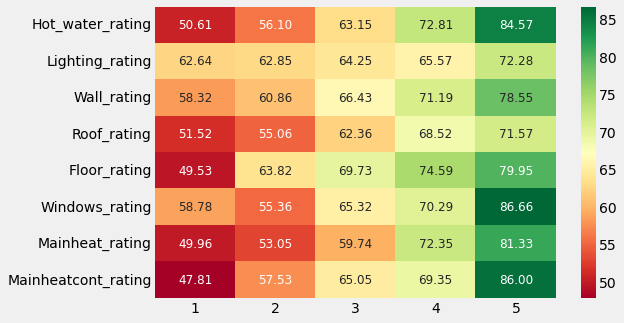

In [7]:
# calculate averages
df_out = pd.DataFrame(index = range(1,6))

df1 = df[feats_used + feats_trg]
for f in feats_used:
    df1[f] = df1[f].fillna(0).astype(int)
    df2 = df1[df1[f]!=0].groupby(f)[feats_trg[0]].mean()
    df_out[f] = df2

_, ax = plt.subplots(1,1, figsize = (8,5))
p = sns.heatmap(df_out.T, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_ylabel('')

In [8]:
# calculate improvements:
df_imp = df_out.diff()[1:]
df_imp.index = [1,2,3,4]
df_imp = df_imp.to_dict()

feats_imp = []
for f in feats_used:
    df1[f+'_improve'] = df1[f].map(df_imp[f])
    feats_imp.append(f+'_improve')

df1['improve_eff'] = df1[feats_imp].max(axis = 1)
df1['improve_eff_feat'] = df1[feats_imp].idxmax(axis = 1).str[:-15]

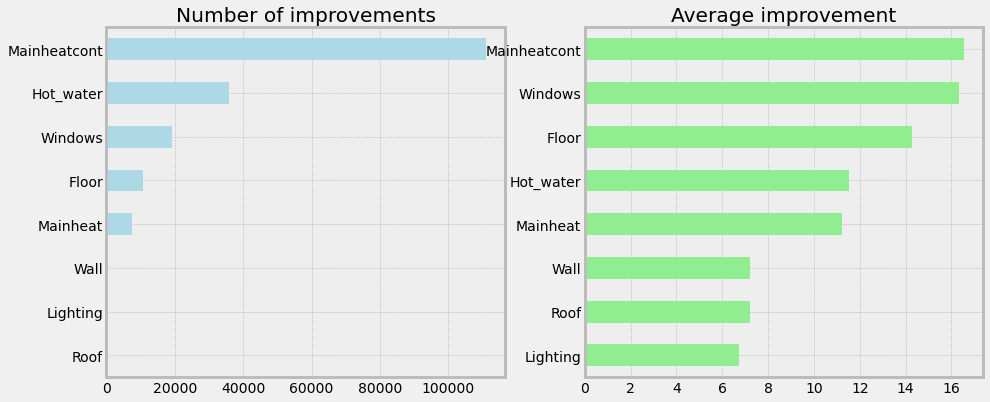

In [9]:
# popularity by wall types and insulation
_, ax = plt.subplots(1,2, figsize = (14,6))
_ = df1.groupby('improve_eff_feat').size().sort_values().plot(kind = 'barh', ax = ax[0], ylabel = '', color = 'lightblue', title = 'Number of improvements')
_ = df1.groupby('improve_eff_feat')['improve_eff'].mean().sort_values().plot(kind = 'barh', ax = ax[1], ylabel = '', color = 'lightgreen', title = 'Average improvement')

### energy costs

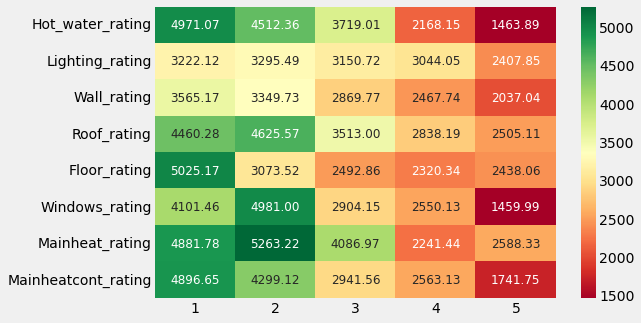

In [10]:
# calculate averages
df_out = pd.DataFrame(index = range(1,6))

df1 = df[feats_used + feats_trg]
for f in feats_used:
    df1[f] = df1[f].fillna(0).astype(int)
    df2 = df1[df1[f]!=0].groupby(f)[feats_trg[1]].mean()
    df_out[f] = df2

_, ax = plt.subplots(1,1, figsize = (8,5))
p = sns.heatmap(df_out.T, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_ylabel('')

In [11]:
# calculate improvements:
df_imp = -df_out.diff()[1:]
df_imp.index = [1,2,3,4]
df_imp = df_imp.to_dict()

feats_imp = []
for f in feats_used:
    df1[f+'_improve'] = df1[f].map(df_imp[f])
    feats_imp.append(f+'_improve')

df1['improve_eff'] = df1[feats_imp].max(axis = 1)
df1['improve_eff_feat'] = df1[feats_imp].idxmax(axis = 1).str[:-15]

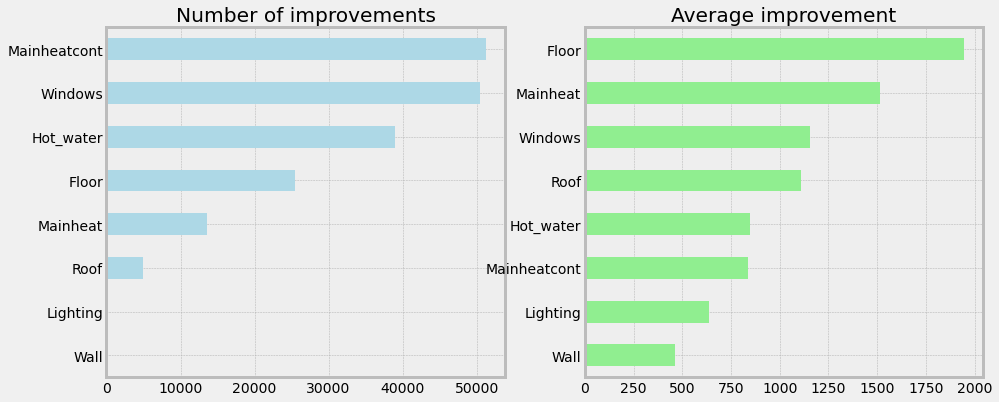

In [12]:
# popularity by wall types and insulation
_, ax = plt.subplots(1,2, figsize = (14,6))
_ = df1.groupby('improve_eff_feat').size().sort_values().plot(kind = 'barh', ax = ax[0], ylabel = '', color = 'lightblue', title = 'Number of improvements')
_ = df1.groupby('improve_eff_feat')['improve_eff'].mean().sort_values().plot(kind = 'barh', ax = ax[1], ylabel = '', color = 'lightgreen', title = 'Average improvement')